In [11]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [12]:
import numpy as np
import pandas as pd

In [13]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [1]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [2]:
#connect to the sqlite database.
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [3]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine,reflect = True)

In [5]:
#View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [7]:
# Create the session (link) from Python to the Hawaii Weather database
session = Session(engine)

# Exploratory Climate Analysis

('2017-08-23',)


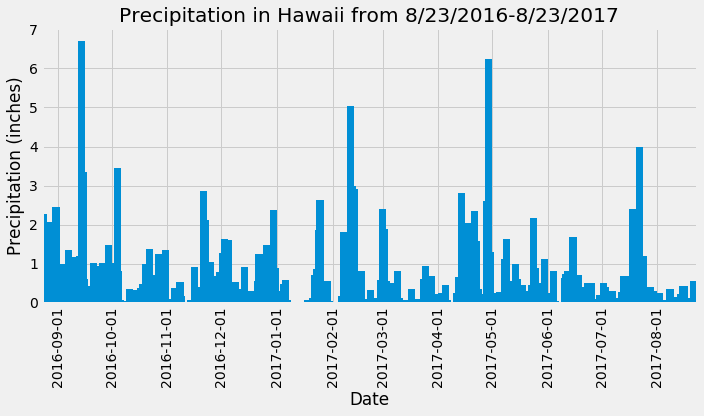

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)
one_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
#Get the last date in correct format
final_date = dt.date(2017, 8, 23)

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all()
df = pd.DataFrame(prcp, columns=['date','precipitation'])
#Convert date to datetime format
df['date']=pd.to_datetime(df['date'])

# Sort the dataframe by date
df.set_index('date', inplace=True)
df.sort_index(inplace=True)
#Get rid of NaN values
clean_df = df.dropna(how='any')

# Use Pandas Plotting with Matplotlib to plot the data
from matplotlib.dates import MonthLocator, DateFormatter

#reset index so the date is on its own column again
new_df = clean_df.reset_index()
#Create plot 
fig, ax = plt.subplots(figsize=(10, 6))

# Add x-axis and y-axis
ax.bar(new_df['date'],
       new_df['precipitation'],width=4)
ax.set(xlabel="Date",
       ylabel="Precipitation (inches)",
       title="Precipitation in Hawaii from 8/23/2016-8/23/2017")
#set the xlimits to correct time frame
ax.set_xlim(one_year_ago,final_date)
#Set the xaxis ticks to increment by 1 month 
ax.xaxis.set_major_locator(MonthLocator(bymonthday=1))
#format date to show year-month-day
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [15]:
# Use Pandas to calculate the summary statistics for the precipitation data
clean_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dataset?
count = len(session.query(Measurement.station).group_by(Measurement.station).all())
print(f" There are {count} stations available in this dataset.")

 There are 9 stations available in this dataset.


In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
max_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
min_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
print(f"The lowest temperature recorded from USC00519281 was {min_temp} degrees")
print(f"The highest temperature recorded from USC00519281 was {max_temp} degrees")
print(f"The average temperature from USC00519281 was {avg_temp} degrees")

The lowest temperature recorded from USC00519281 was [(54.0,)] degrees
The highest temperature recorded from USC00519281 was [(85.0,)] degrees
The average temperature from USC00519281 was [(71.66378066378067,)] degrees


352


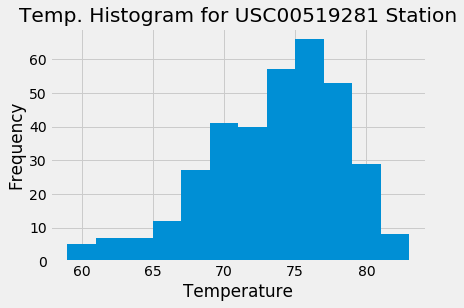

In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_obs = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == 'USC00519281').\
filter(Measurement.date >= one_year_ago).all()
df = pd.DataFrame(most_obs)
plt.hist(df['tobs'],bins =12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title("Temp. Histogram for USC00519281 Station")
print(len(most_obs))

## Bonus Challenge Assignment

### Temperature Analaysis I

In [20]:
#Identify the average temperature in June at all stations across all available years in the dataset. 
#Do the same for December temperature.
june_avg = session.query(func.avg(Measurement.tobs)).filter(func.strftime("%m", Measurement.date) == "06").all()
dec_avg= session.query(func.avg(Measurement.tobs)).filter(func.strftime("%m", Measurement.date)=="12").all()
print(f"The average temperature in June is {june_avg} degrees")
print(f"The average temperature in December is {dec_avg} degrees")

The average temperature in June is [(74.94411764705882,)] degrees
The average temperature in December is [(71.04152933421226,)] degrees


In [21]:
#Use the t-test to determine whether the difference in the means, if any, is statistically significant. 
#Will you use a paired t-test, or an unpaired t-test? Why?
import scipy.stats as stats

#Query data to use for t-test
june_data = session.query(Measurement.tobs).filter(func.strftime("%m", Measurement.date) == "06").all()
dec_data= session.query(Measurement.tobs).filter(func.strftime("%m", Measurement.date)=="12").all()

stats.ttest_ind(june_data, dec_data)

#Hawaii is reputed to enjoy mild weather all year. Is there a meaningful difference between the temperature in, 
#for example, June and December?

Ttest_indResult(statistic=array([31.60372399]), pvalue=array([3.9025129e-191]))

#### I used an unpaired t-test because it is designed to compare the means of different groups or items under two separate scenarios (summer and winter). Because the p-value is less than 0.5 and the t-value is large, that indicates the difference between the means is reliable/statistically significant. 

### Temperature Analysis II

In [24]:
from datetime import datetime
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
    Returns:
        TMIN, TAVE, and TMAX
    """
    #Convert string dates to datetime format
    num_start = datetime.strptime(start_date, '%Y-%m-%d')
    num_end = datetime.strptime(end_date,'%Y-%m-%d')
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= num_start).filter(Measurement.date <= num_end).all()

# function usage example
print("This function calculates the minimum, average, and maximum temperature in Hawaii for a given date range:")
print(calc_temps('2015-01-1', '2017-01-1'))

This function calculates the minimum, average, and maximum temperature in Hawaii for a given date range:
[(56.0, 74.00444162436548, 86.0)]


In [25]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2014-01-1','2015-01-1'))

[(56.0, 73.25635103926096, 85.0)]


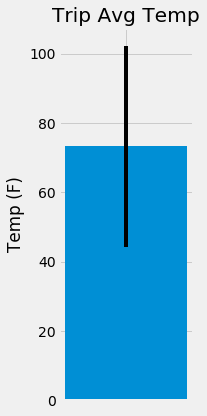

In [26]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots(figsize= (3,6))
x_pos = np.arange(1)

ax.bar(x_pos,73.26,yerr= (85-56),align = 'center')
ax.set_ylabel("Temp (F)")
ax.set_title("Trip Avg Temp")
ax.set_xticks(x_pos)
ax.set_xticklabels("")

plt.tight_layout()
plt.show()

## Daily Rainfall Average

In [27]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date = dt.datetime(2014,1,1)
end_date = dt.datetime(2015,1,1)

#Select the data we need from each table
sel = [Measurement.station, func.sum(Measurement.prcp), Station.name, Station.latitude, Station.longitude,Station.elevation]

#Join the two tables together on station ID
data = session.query(*sel).filter(Station.station == Measurement.station).filter(Measurement.date >= start_date).\
filter(Measurement.date <= end_date).group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()

for station in data:
    print(station)

('USC00516128', 144.5500000000001, 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)
('USC00519281', 89.85000000000002, 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9)
('USC00513117', 58.42000000000002, 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6)
('USC00519523', 45.92000000000004, 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5)
('USC00514830', 39.309999999999995, 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)
('USC00511918', 21.940000000000005, 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9)
('USC00519397', 21.190000000000005, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)
('USC00517948', 7.209999999999996, 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)
('USC00518838', 0.51, 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)


In [28]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    #Create a list of dates for your trip in the format `%m-%d`. Use the `daily_normals` function to calculate 
    #the normals for each date string and append the results to a list.
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [33]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
start_date = '01-01-2015'
end_date = '01-07-2015'
# Use the start and end date to create a range of dates
start_date = dt.datetime(2015,1,1)
numdays = 7
dateList = []
for x in range (numdays):
    dateList.append(start_date + dt.timedelta(days = x))

# Stip off the year and save a list of %m-%d strings
list_strings = []
for date in dateList:
    list_strings.append(date.strftime('%m-%d'))
print(f"Range of dates: {list_strings}")  

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for date in list_strings:
    normals.append(daily_normals(date))
print(f"Normal for each date: {normals}")

Range of dates: ['01-01', '01-02', '01-03', '01-04', '01-05', '01-06', '01-07']
Normal for each date: [[(62.0, 69.15384615384616, 77.0)], [(60.0, 69.39622641509433, 77.0)], [(62.0, 68.9090909090909, 77.0)], [(58.0, 70.0, 76.0)], [(56.0, 67.96428571428571, 76.0)], [(61.0, 68.96491228070175, 76.0)], [(57.0, 68.54385964912281, 76.0)]]


In [34]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
t_min = []
t_avg = []
t_max = []
#Unpack data to get min,avg,and max values in separate lists
for val in normals:
    for t in val:
        t_min.append(t[0])
        t_avg.append(t[1])
        t_max.append(t[2])
#Create the dataframe
df = pd.DataFrame({'Tmin': t_min,'Tavg': t_avg,'Tmax':t_max}, index=list_strings)
df

,Tmin,Tavg,Tmax
01-01,62.0,69.153846,77.0
01-02,60.0,69.396226,77.0
01-03,62.0,68.909091,77.0
01-04,58.0,70.000000,76.0
01-05,56.0,67.964286,76.0
01-06,61.0,68.964912,76.0
01-07,57.0,68.543860,76.0


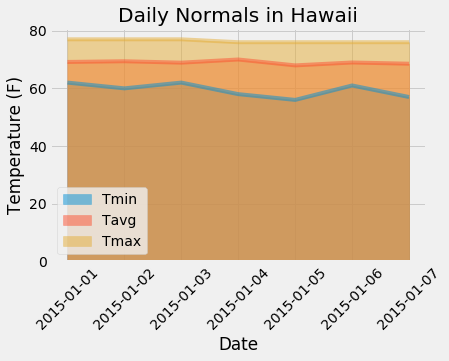

In [35]:
# Plot the daily normals as an area plot with `stacked=False`
df.plot(kind='area', stacked=False)

#Get x lables in right format with year included
list_strings = []
for date in dateList:
    list_strings.append(date.strftime('%Y-%m-%d'))

x_pos = np.arange(len(list_strings))
plt.xticks(x_pos,list_strings,rotation = 45)

plt.title("Daily Normals in Hawaii")
plt.xlabel("Date")
plt.ylabel("Temperature (F)")
plt.show(block=True)